In [1]:
# 配置路径与导入库
import sys, os, random, time, math, pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# 将仓库根目录加入 sys.path 以便导入本地模块
repo_root = Path('g:/Thomas/3_1_project')
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# 可选：固定随机种子，结果更可复现
random.seed(42)
np.random.seed(42)

In [2]:
# 导入数据集与CLIP分类类
%load_ext autoreload
%autoreload 2

# Tiny ImageNet 数据集类（我们在 tiny_imagenet_dataset.py 中定义）
from clip_classification.tiny_imagenet_dataset import TinyImageNetDataset, create_dataloaders

# 直接使用OpenAI CLIP做零样本推理做描述/标签
import torch, clip

print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

Torch: 2.6.0+cu126
CUDA available: True


In [3]:
# 初始化CLIP与设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device=device)
model.eval()
print('Using device:', device)

Using device: cuda


✓ 加载 val 集: 2500 张图像, 50 个类别
Batch images: torch.Size([12, 3, 64, 64]) labels: torch.Size([12])


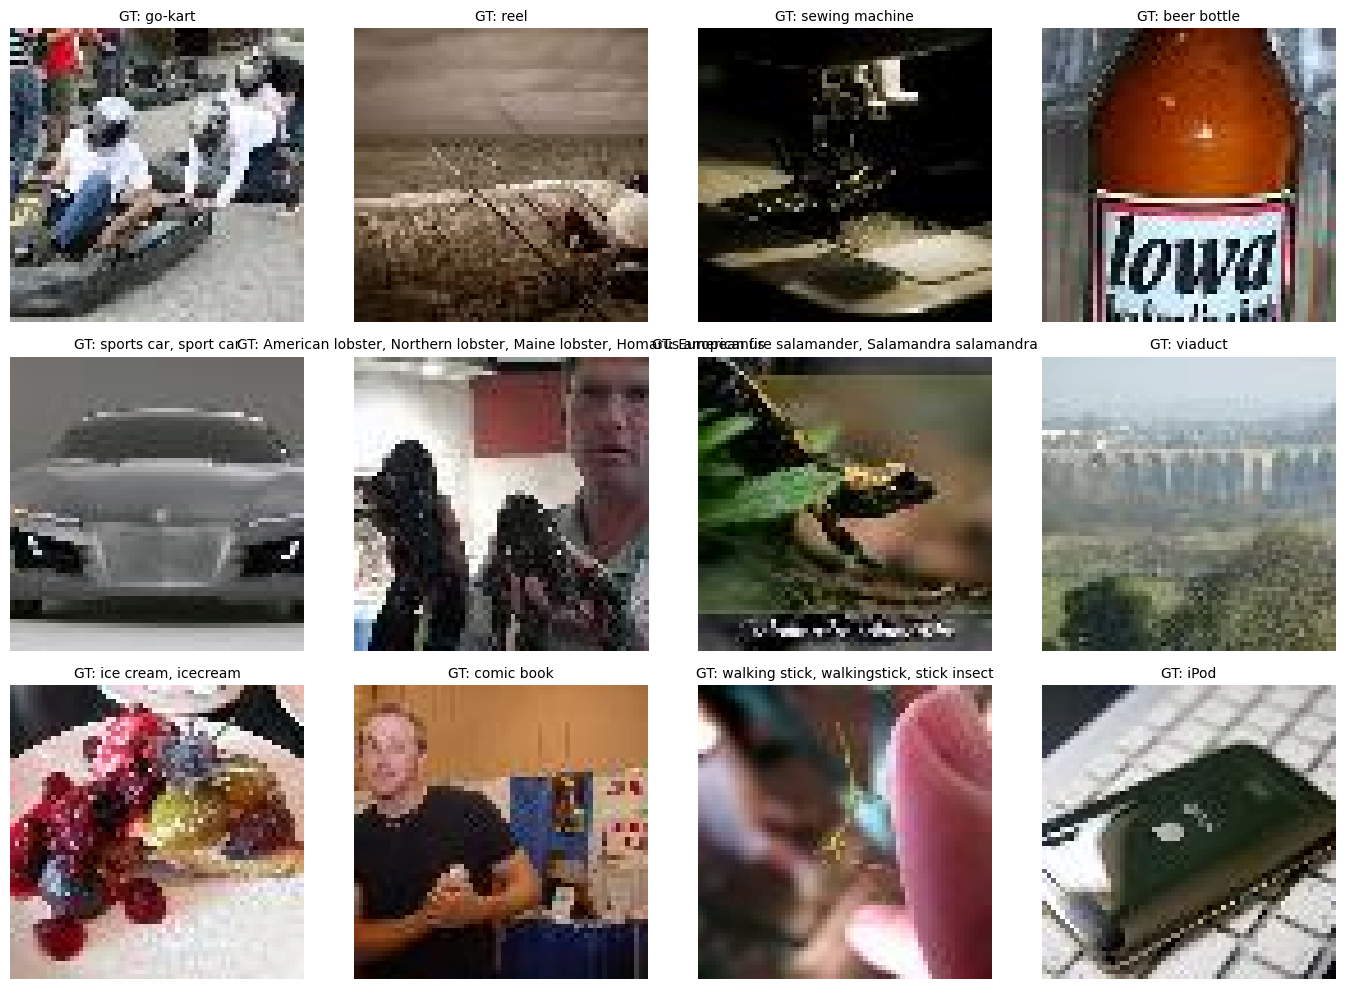

In [4]:
# 加载验证集，取一批图片做可视化
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

data_root = 'g:/Thomas/3_1_project/data/tiny-imagenet-200'
num_classes = 50  # 可改为 200
batch_size = 12

# 使用与训练一致的变换（64x64 + 标准化）
from clip_classification.tiny_imagenet_dataset import get_transforms
val_ds = TinyImageNetDataset(root=data_root, split='val', transform=get_transforms(64, is_training=False), num_classes=num_classes)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# 取一批样本
images, labels = next(iter(val_loader))
print('Batch images:', images.shape, 'labels:', labels.shape)

# 反标准化用于可视化
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
def denorm(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * IMAGENET_STD + IMAGENET_MEAN).clip(0,1)
    return img

# 显示 3x4 网格，标题为真值类别名
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()
for i in range(batch_size):
    ax = axes[i]
    ax.imshow(denorm(images[i]))
    gt_name = val_ds.get_class_name(labels[i].item())
    ax.set_title(f'GT: {gt_name}', fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

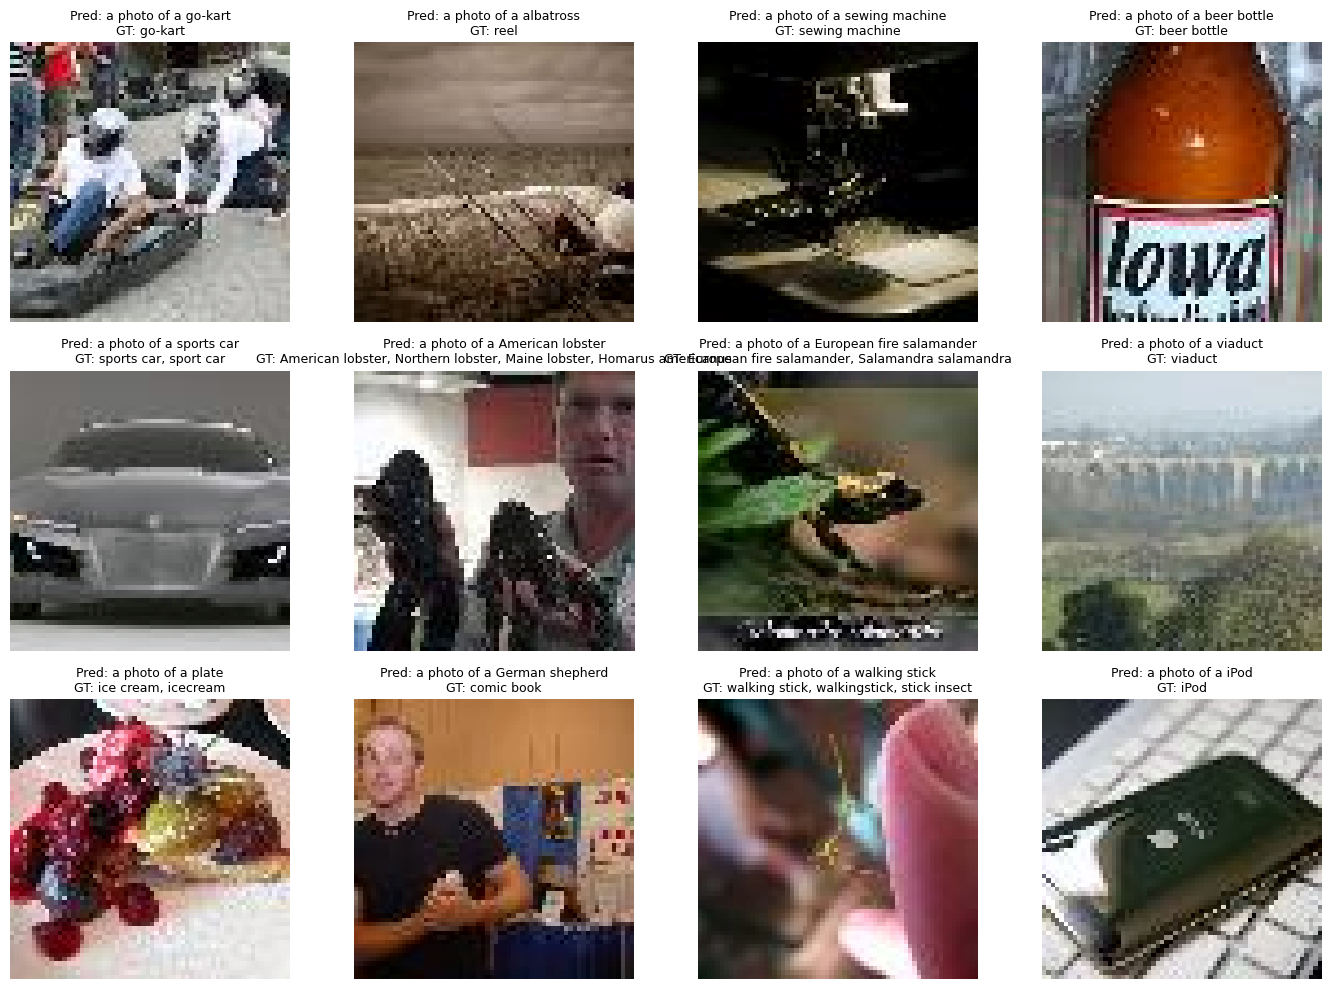

In [5]:
# 使用CLIP对同一批图像做零样本预测，并显示预测描述
import torch.nn.functional as F

# 1) 构建文本标签：使用所选类别的名称，模板化为短描述
wnids = val_ds.wnids
class_texts = []
for wnid in wnids:
    name = val_ds.class_names.get(wnid, wnid)
    # 取第一个逗号前的主名称，并简单模板化
    short = name.split(',')[0]
    class_texts.append(f'a photo of a {short}')

# 2) 对一批图像逐个用CLIP的预处理再推理（CLIP期望自己的预处理）
#    我们重新根据 val_ds.samples 的文件路径读取对应图片以确保与CLIP预处理一致
batch_indices = list(range(batch_size))
clip_imgs = []
for idx in batch_indices:
    # 假设val_loader是按顺序提供样本的，batch 0 对应样本 0..batch_size-1
    img_path, _ = val_ds.samples[idx]
    pil = Image.open(img_path).convert('RGB')
    clip_imgs.append(preprocess(pil))
clip_img_tensor = torch.stack(clip_imgs).to(device)

# 3) 文本编码
text_tokens = clip.tokenize(class_texts).to(device)

# 4) 前向计算
with torch.no_grad():
    image_features = model.encode_image(clip_img_tensor)
    text_features = model.encode_text(text_tokens)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits = image_features @ text_features.T
    probs = logits.softmax(dim=-1).cpu().numpy()

# 5) 可视化：在每张图上方显示 Top-1 预测描述
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()
for i in range(batch_size):
    ax = axes[i]
    ax.imshow(denorm(images[i]))
    top1 = probs[i].argmax()
    pred_text = class_texts[top1]
    gt_name = val_ds.get_class_name(labels[i].item())
    ax.set_title(f'Pred: {pred_text}\nGT: {gt_name}', fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# 可选：将结果保存为CSV
import pandas as pd
from datetime import datetime

rows = []
for i in range(batch_size):
    top1 = probs[i].argmax()
    rows.append({
        'filename': Path(val_ds.samples[i][0]).name,
        'gt_name': val_ds.get_class_name(labels[i].item()),
        'pred_text': class_texts[top1],
        'pred_prob': float(probs[i][top1])
    })

df = pd.DataFrame(rows)
results_dir = Path('g:/Thomas/3_1_project/clip_classification/results')
results_dir.mkdir(parents=True, exist_ok=True)
out_csv = results_dir / f'clip_zeroshot_results_{num_classes}cls_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print('Saved:', out_csv)

Saved: g:\Thomas\3_1_project\clip_classification\results\clip_zeroshot_results_50cls_20251026_170511.csv
